# <font color='Purple'>**Working with DICOM Image format**</font>

## <font color='green'>**1. Dataset Information**</font>
The data is taken from here (https://zenodo.org/record/16956#.YFMM5PtKiV5), "An MRI DICOM data set of the head of a normal male human aged 52", by Lionheart, William R.B.

This zip file contains a DICOM data set of magnetic resonance images  a normal male mathematics professor aged 52. The experimental subject is the author. The MRI scans are T2 weighted  turbo-spin-echo (T2W TSE) and T1 weighted Fast Field Echo (T1W FFE).

The subject suffers from a small vertical strabismus (hypertropia), a misalignment of the eyes, which is visible in this data set.

The author would like to thank the Radiology Department at the Macclesfield General Hospital for performing the scan.

**License**: License (for files):
 [Creative Commons Attribution Share Alike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

**Data Citation**: Lionheart, W. R. B. (2015). An MRI DICOM data set of the head of a normal male human aged 52 [Data set]. Zenodo. https://doi.org/10.5281/zenodo.16956

## <font color='green'>**2. Import the Required Libraries & Modules**</font>
* pathlib for easy path handling
* pydicom to handle dicom files
* matplotlib for visualization
* numpy to create the 3D container

In [1]:
from pathlib import Path
import pydicom 
import matplotlib.pyplot as plt
import numpy as np

## <font color='green'>**3. Load the DICOM files of MRI Head images**</font>
Use the glob function to return all items in a directory which correspond to the provided pattern.
As in this case, the directory only contains the DICOM files, all files in it can be extracted("*")

In [2]:
head_mri = Path("/kaggle/input/zenodo-mri-dicom-data-set/SE000001")
all_files = list(head_mri.glob("*"))  # as glob returns a generator, convert it to a list
all_files  # make sure that all files are present in the list

[PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000023'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000006'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000007'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000016'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000013'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000012'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000011'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000004'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000026'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000020'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000003'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000002'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000015'),
 PosixPath('/kaggle/input/zenodo-mri-dicom-data-set

Read these files by using the read_file method and append them to a list

In [3]:
data_mri_head = []

for path in all_files:
    data = pydicom.read_file(path) # read the single DICOM files
    data_mri_head.append(data)
print(len(data_mri_head))

27


As can be seen from the printed paths above, it is possible that the DICOM files are not ordered according to their actual image position! This can be verified by inspecting the SliceLocation

In [4]:
### unordered slices ###
for slice in data_mri_head[:5]: # just show the first 5 slices
    print(slice.SliceLocation) # this is the location of the within the scanner coordinate system

137.999998321624
35.9999959546749
41.9999963629367
95.9999960937442
77.9999962275740


It is crucial to order them, as, complete scan of unordered slices would be shuffeled and useless. To order these slices use the "SliceLocation" attribute passed to the *sorted* function to identify the 2D slice position and thus order the slices

In [5]:
# this sorts the slices according to their location
mri_data_ordered = sorted(data_mri_head, key=lambda slice: slice.SliceLocation) 

### Ordered slices ###
for slice in mri_data_ordered[:5]:
    print(slice.SliceLocation)

0.0
5.99999663091323
11.9999973042441
17.9999979772582
23.9999946081714


Now repeat the extraction of the actual data (pixel_arrays) from the Dicom files and store them in a list.

In [6]:
dicom_images = []
for slice in mri_data_ordered:
    dicom_images.append(slice.pixel_array) # fill the 3D array in a slice-per-slice manner
dicom_images = np.array(dicom_images)
print(dicom_images.shape)

(27, 256, 256)


## <font color='green'>**4. Dataset Visualization**</font>
Glimpse of some of slices of the ordered 3D icom_images:

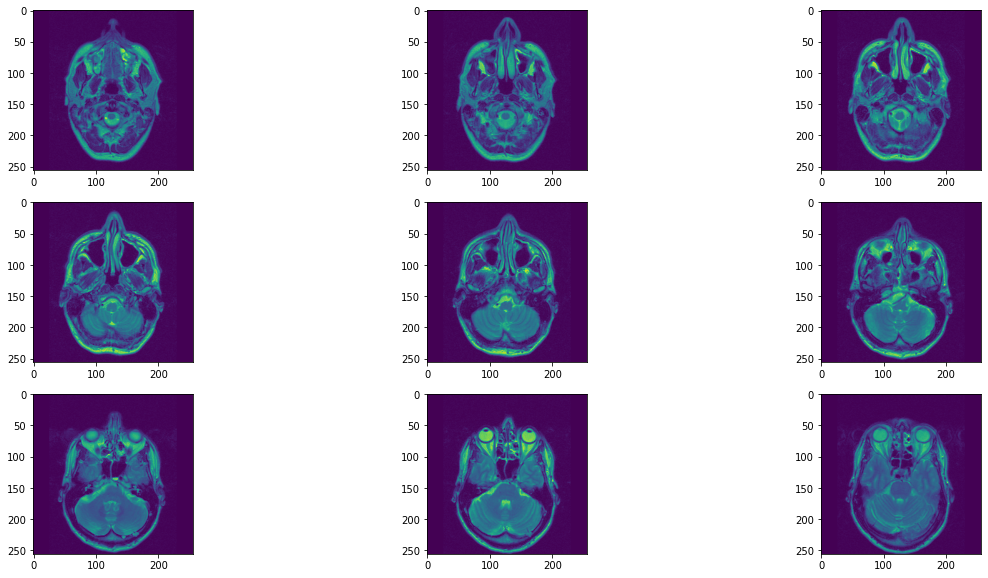

<Figure size 432x288 with 0 Axes>

In [7]:
plt.figure(figsize=(20,10))
for i in range (9):
  plt.subplot(3,3,i+1)
  plt.imshow(dicom_images[i])
plt.show();
plt.tight_layout();

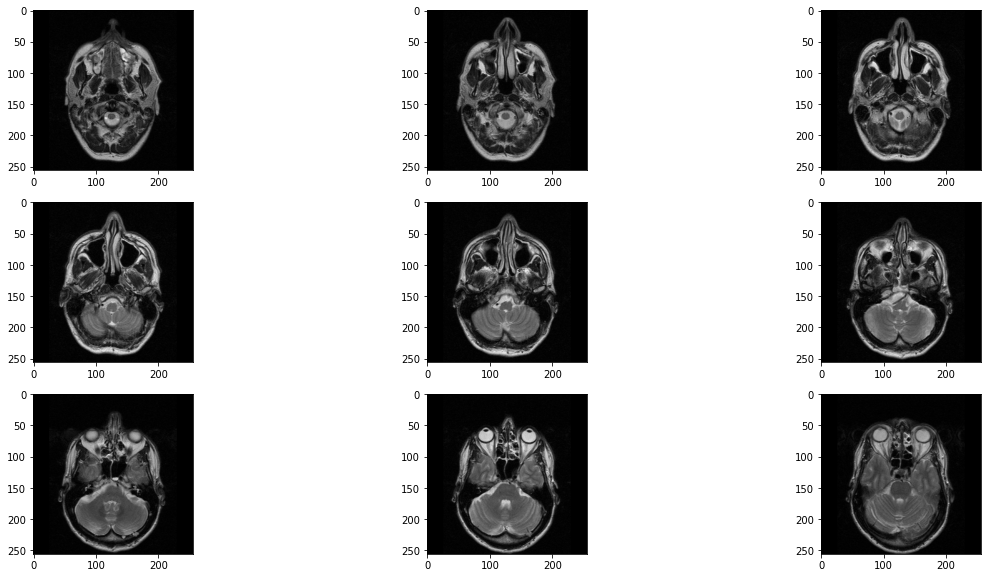

In [8]:
fig, axis = plt.subplots(3, 3, figsize=(20, 10))
slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(dicom_images[slice_counter], cmap="gray")
        slice_counter+=1

## **5. SimpleITK**
SimpleITK  https://pypi.org/project/SimpleITK/ provides functionality to automatically detect and read all dicom files without manually managing the file reading or slice ordering. Steps involved are:

1. Get Series Ids of all files in the directory. This is important as there also might be multiple scans in the same directory and we do not want to mix them. *ImageSeriesReader.GetGDCMSeriesIDs(path)* handles this and returns all Ids it can find.
2. Then return all file names in the directory with the desired Id. *ImageSeriesReader.GetGDCMSeriesFileNames(path, ID)* provides this functionality
3. Next step is to define the image reader called *ImageSeriesReader()* and feed it the file names using SetFileNames(file_names)
4. After that, execute the reader in order to get the desired data by calling *Execute()*
5. Finally, convert the sitk image object to a numpy array. This can be done by calling GetArrayFromImage(image_data)

## **Imports**
* SimpleITK to read 3D volumes in dcm format

In [9]:
import SimpleITK as sitk
#Step 1: Get Series Ids
series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(head_mri))
print(series_ids)

('1.3.46.670589.11.0.0.11.4.2.0.12098.5.4500.2015011413262801702',)


In [10]:
#Step 2: Get Series file names
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(head_mri), series_ids[0])
series_file_names  # Notice how the files are already ordered

('/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000000',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000001',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000002',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000003',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000004',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000005',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000006',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000007',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000008',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000009',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000010',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000011',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000012',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000013',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000014',
 '/kaggle/input/zenodo-mri-dicom-data-set/SE000001/MR000015',
 '/kaggl

In [11]:
#Step 3: Define the image reader & feed it the file name
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

#Step 4: Execute the reader
image_data = series_reader.Execute()
print(image_data.GetSize()) # show the size of the 3D image array

(256, 256, 27)


This is all to be done to get a full volumetric data. As can be seen, the shape is (256, 256, 27), different from the one obtained above, where the shape was (27, 256, 256). This is just due to a different order of image dimensions.

In [12]:
#Step 4: Conversion of the sitk image object to a numpy array
head_mri = sitk.GetArrayFromImage(image_data)
print(type(head_mri))
print(head_mri.shape)

<class 'numpy.ndarray'>
(27, 256, 256)


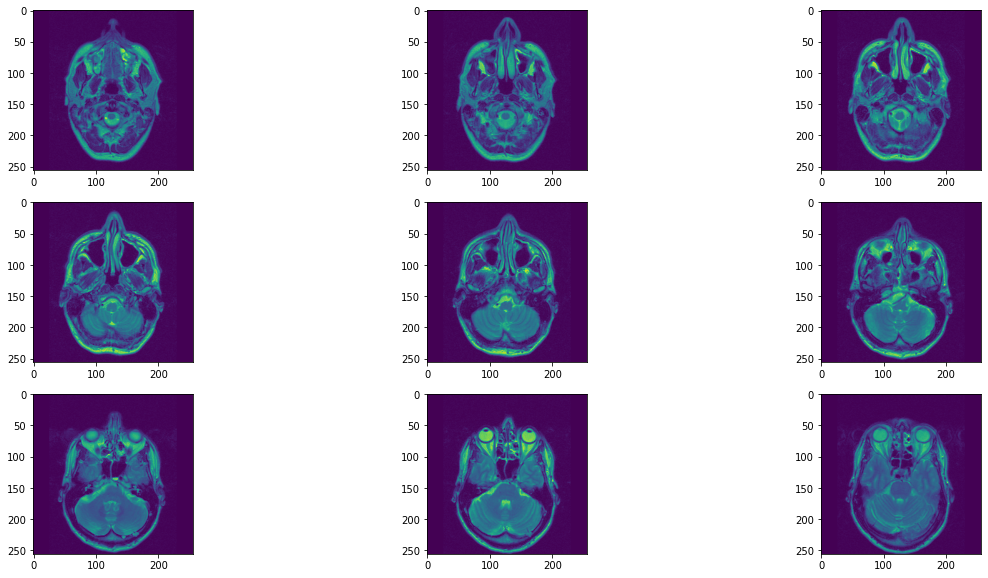

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(20,10))
for i in range (9):
  plt.subplot(3,3,i+1)
  plt.imshow(head_mri[i])
plt.show();
plt.tight_layout();

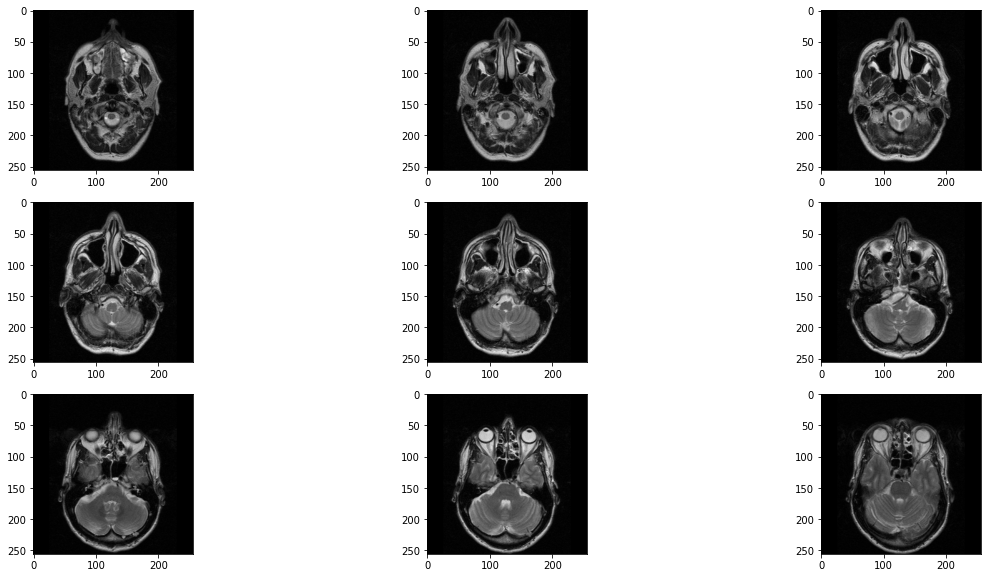

In [14]:
fig, axis = plt.subplots(3, 3, figsize=(20, 10))

slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(head_mri[slice_counter], cmap="gray")
        slice_counter+=1